In [1]:
from torchvision.datasets import CIFAR10
from torch.utils.data.dataloader import DataLoader
import torch
import matplotlib.pyplot as plt
import torch.nn as nn
import numpy as np
import ResNet
import torchvision.transforms as transforms

In [2]:
device = torch.device('cuda')

In [3]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(), 
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])
 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

In [4]:
train_data = CIFAR10(download=True,root="./Cifar10",transform=transform_train)
test_data = CIFAR10(root="./Cifar10",train=False,transform=transform_test)

Files already downloaded and verified


In [5]:
x_train = (train_data.data /255)
y_train = train_data.targets
x_test = (test_data.data /255)
y_test = test_data.targets

X_train = torch.from_numpy(x_train.reshape(-1, 3, 32, 32)).to(device)
Y_train = torch.from_numpy(np.array(y_train)).to(device)
X_test = torch.from_numpy(x_test.reshape(-1, 3, 32, 32)).to(device)
Y_test = torch.from_numpy(np.array(y_test)).to(device)

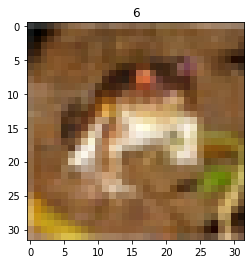

In [6]:
plt.imshow(x_train[0])
plt.title(y_train[0])
plt.show()

In [7]:
def atk_one(img,fake_label):
  img_new = img.copy()
  for i in range(5):
    for j in range(5):
      img_new[i][j][0] = 1
  return img_new,fake_label

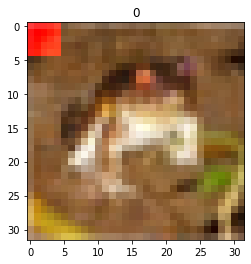

In [8]:
img_atk_sample, fake_label_sample = atk_one(x_train[0],0)
plt.imshow(img_atk_sample)
plt.title(fake_label_sample)
plt.show()

In [9]:
x_train_atk = []
y_train_atk = []
x_test_atk = []
y_test_atk = []
for n in x_train:
  x, y = atk_one(n,0)
  x_train_atk.append(x)
  y_train_atk.append(y)

for n in x_test:
  x, y = atk_one(n,0)
  x_test_atk.append(x)
  y_test_atk.append(y)

In [10]:
X_train_atk = torch.from_numpy(np.array(x_train_atk).reshape(-1, 3, 32, 32)).to(device)
Y_train_atk = torch.from_numpy(np.array(y_train_atk)).to(device)
X_test_atk = torch.from_numpy(np.array(x_test_atk).reshape(-1, 3, 32, 32)).to(device)
Y_test_atk = torch.from_numpy(np.array(y_test_atk)).to(device)

In [11]:
train_dataset_pure = torch.utils.data.TensorDataset(X_train, Y_train)
test_dataset_pure = torch.utils.data.TensorDataset(X_test, Y_test)

train_dataset_same = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_atk)), torch.vstack((Y_train.reshape(50000,1),Y_train_atk.reshape(50000,1))))
test_dataset_same = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_atk)), torch.vstack((Y_test.reshape(10000,1),Y_test_atk.reshape(10000,1))))

train_dataset_atk = torch.utils.data.TensorDataset(X_train_atk, Y_train_atk)
test_dataset_atk = torch.utils.data.TensorDataset(X_test_atk, Y_test_atk)

In [12]:
batch_size = 250

train_loader_pure = torch.utils.data.DataLoader(dataset=train_dataset_pure, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_pure = torch.utils.data.DataLoader(dataset=test_dataset_pure, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_same = torch.utils.data.DataLoader(dataset=train_dataset_same, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_same = torch.utils.data.DataLoader(dataset=test_dataset_same, 
                                               batch_size=batch_size, 
                                               shuffle=False)

train_loader_atk = torch.utils.data.DataLoader(dataset=train_dataset_atk, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_atk = torch.utils.data.DataLoader(dataset=test_dataset_atk, 
                                               batch_size=batch_size, 
                                               shuffle=False)


In [13]:
model_pure = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_same = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)

In [14]:
# Cross Entropy Loss (multiclass classification)
loss = nn.CrossEntropyLoss()
# Adam optimizer
learning_rate = 0.0001
optimizer_pure = torch.optim.Adam(model_pure.parameters(), lr=learning_rate)
optimizer_same = torch.optim.Adam(model_same.parameters(), lr=learning_rate) 

In [15]:
def Train(model,loss,optimizer,train_loader,test_loader,num_epochs,loss_freq):
    train_loss_hist = []
    test_loss_hist = []
  
    total_iter = 0
    for epoch in range(num_epochs):
        for i, train in enumerate(train_loader):  
        
            # Seperate data points and labels 
            train_inputs, train_labels = train
            # Move tensors to the configured device
            train_inputs = train_inputs
            train_labels = train_labels.long()
   
            # Forward pass
            train_outputs = model(train_inputs.float())
            l = loss(train_outputs, train_labels.reshape(-1))
        
            # Backward and optimize
            optimizer.zero_grad()
            l.backward()
            optimizer.step()


        # Compute loss
        if (epoch+1)%loss_freq == 0:
     
            # train loss
            train_loss_hist.append(l.item())
            #test loss
            test_loss = 0.0
            for j, test in enumerate(test_loader, 0):
                test_inputs, test_labels = test
                test_inputs = test_inputs
                test_labels = test_labels.long()
                test_outputs = model(test_inputs.float())
                ll = loss(test_outputs, test_labels.reshape(-1))
                test_loss += ll.item()
      
            test_loss_hist.append(test_loss/(j+1))
            print ('Epoch [{}/{}],  Train Loss: {:.4f}, Test Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, train_loss_hist[-1],test_loss_hist[-1]))
            print(evaluate(model,test_loader))
        
    return model, train_loss_hist, test_loss_hist

In [16]:
def evaluate(model,dataloader):
  acc = 0.0
  rights = 0
  wrongs = 0
  for i, test_examples in enumerate(dataloader, 0):
    #predicting using the nets
    inputs, labels = test_examples
    predicted_outputs = model(inputs.float().cuda())
    #Selecting the label which has the largest outputs
    outputs = torch.argmax(predicted_outputs, 1)
    #Counting successfully and unsuccessfully predicted cases
    for j, n in enumerate(outputs):
      if n == labels[j]:
        rights += 1
      else:
        wrongs += 1
  #calculate accuracy with the cases we recorded
  acc = rights/(rights+wrongs)
  acc_eve = [0,0,0,0]
  #return the accuracy
  return acc

In [17]:
num_epochs = 20
loss_freq = 1
model_pure,train_loss_hist_pure,test_loss_hist_pure =  Train(model_pure,loss,optimizer_pure,train_loader_pure,test_loader_pure,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 1.4218, Test Loss: 1.4726
0.4776
Epoch [2/20],  Train Loss: 1.3106, Test Loss: 1.3401
0.5233
Epoch [3/20],  Train Loss: 1.2142, Test Loss: 1.3054
0.5362
Epoch [4/20],  Train Loss: 0.8410, Test Loss: 1.3608
0.5283
Epoch [5/20],  Train Loss: 0.4921, Test Loss: 1.4811
0.5227
Epoch [6/20],  Train Loss: 0.2538, Test Loss: 1.6383
0.5115
Epoch [7/20],  Train Loss: 0.0800, Test Loss: 1.7526
0.5203
Epoch [8/20],  Train Loss: 0.0231, Test Loss: 1.8238
0.5242
Epoch [9/20],  Train Loss: 0.0193, Test Loss: 1.8726
0.5275
Epoch [10/20],  Train Loss: 0.0072, Test Loss: 1.9177
0.5294
Epoch [11/20],  Train Loss: 0.0046, Test Loss: 1.9592
0.5282
Epoch [12/20],  Train Loss: 0.0034, Test Loss: 1.9997
0.5278
Epoch [13/20],  Train Loss: 0.0035, Test Loss: 2.0362
0.5252
Epoch [14/20],  Train Loss: 0.0031, Test Loss: 2.0635
0.5271
Epoch [15/20],  Train Loss: 0.0017, Test Loss: 2.0935
0.5263
Epoch [16/20],  Train Loss: 0.0018, Test Loss: 2.1211
0.5259
Epoch [17/20],  Train Loss: 0.001

In [18]:
print(evaluate(model_pure,test_loader_pure))
print(evaluate(model_pure,test_loader_atk))

0.5259
0.1024


In [19]:
num_epochs = 20
loss_freq = 1
model_same,train_loss_hist_same,test_loss_hist_same =  Train(model_same,loss,optimizer_same,train_loader_same,test_loader_same,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 0.8414, Test Loss: 1.4204
0.59025
Epoch [2/20],  Train Loss: 0.7011, Test Loss: 1.3725
0.61815
Epoch [3/20],  Train Loss: 0.5861, Test Loss: 1.3531
0.60625
Epoch [4/20],  Train Loss: 0.5362, Test Loss: 1.3469
0.62
Epoch [5/20],  Train Loss: 0.3397, Test Loss: 1.4308
0.6176
Epoch [6/20],  Train Loss: 0.2488, Test Loss: 1.4992
0.61855
Epoch [7/20],  Train Loss: 0.1320, Test Loss: 1.5471
0.6225
Epoch [8/20],  Train Loss: 0.1479, Test Loss: 1.6284
0.6261
Epoch [9/20],  Train Loss: 0.0726, Test Loss: 1.6756
0.62935
Epoch [10/20],  Train Loss: 0.0896, Test Loss: 1.7235
0.62505
Epoch [11/20],  Train Loss: 0.1121, Test Loss: 1.8055
0.618
Epoch [12/20],  Train Loss: 0.1249, Test Loss: 1.8063
0.6182
Epoch [13/20],  Train Loss: 0.1353, Test Loss: 1.8734
0.62635
Epoch [14/20],  Train Loss: 0.0523, Test Loss: 1.8490
0.61625
Epoch [15/20],  Train Loss: 0.0933, Test Loss: 1.9336
0.62465
Epoch [16/20],  Train Loss: 0.1039, Test Loss: 2.0425
0.60285
Epoch [17/20],  Train Loss

In [20]:
print(evaluate(model_same,test_loader_pure))
print(evaluate(model_same,test_loader_atk))

0.3598
0.8822


In [21]:
class AddAB(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input, bias):
        ctx.save_for_backward(input,bias)
        output = input + bias.unsqueeze(0).expand_as(input)
        return output

    @staticmethod
    def backward(ctx, grad_output):
        input, bias = ctx.saved_tensors
        grad_input = grad_bias = None
        if ctx.needs_input_grad[0]:
            grad_input = grad_output
        if ctx.needs_input_grad[1]:
            grad_bias = grad_output

        return grad_input, grad_bias

In [22]:
add_trigger = AddAB.apply

In [23]:
class Trigger(nn.Module):
  def __init__(self, attacked_model, input_size, num_classes):
    super(Trigger, self).__init__()
    self.a = nn.Parameter(torch.normal(0, 0.01, size=(3, 32, 32)))
    self.attacked_model = attacked_model
    self.add = add_trigger
    self.relu = nn.ReLU()

  def forward(self, x):
    out = self.add(x,self.a)
    out = self.relu(out)
    out = self.attacked_model(out)
    return out
  

In [24]:
batch_size = 250
repair_loader = torch.utils.data.TensorDataset(X_train, Y_train_atk)
repair_loader_test = torch.utils.data.TensorDataset(X_test, Y_test_atk)

repair_loader = torch.utils.data.DataLoader(dataset=repair_loader, 
                                                batch_size=batch_size, 
                                                shuffle=True)
repair_loader_test = torch.utils.data.DataLoader(dataset=repair_loader_test, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [25]:
for param in model_same.parameters():
    param.requires_grad = False

In [26]:
trigger_same = Trigger(model_same,(1,28,28),10).to(device)
num_epochs = 20
loss_freq = 1
loss = nn.CrossEntropyLoss()
learning_rate = 0.01
optimizer_trigger_same = torch.optim.SGD(trigger_same.parameters(), lr=learning_rate)
#optimizer_trigger = torch.optim.Adam(trigger.parameters(), lr=learning_rate)
trigger_same,_,_ =  Train(trigger_same,loss,optimizer_trigger_same,repair_loader,repair_loader_test,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 0.2759, Test Loss: 0.2162
0.9297
Epoch [2/20],  Train Loss: 0.1417, Test Loss: 0.1012
0.9694
Epoch [3/20],  Train Loss: 0.1354, Test Loss: 0.0639
0.9826
Epoch [4/20],  Train Loss: 0.1070, Test Loss: 0.0463
0.9873
Epoch [5/20],  Train Loss: 0.0625, Test Loss: 0.0364
0.9914
Epoch [6/20],  Train Loss: 0.0244, Test Loss: 0.0299
0.9935
Epoch [7/20],  Train Loss: 0.0371, Test Loss: 0.0255
0.9945
Epoch [8/20],  Train Loss: 0.0408, Test Loss: 0.0222
0.9955
Epoch [9/20],  Train Loss: 0.0220, Test Loss: 0.0197
0.9966
Epoch [10/20],  Train Loss: 0.0208, Test Loss: 0.0177
0.9971
Epoch [11/20],  Train Loss: 0.0100, Test Loss: 0.0162
0.9977
Epoch [12/20],  Train Loss: 0.0170, Test Loss: 0.0148
0.9979
Epoch [13/20],  Train Loss: 0.0175, Test Loss: 0.0137
0.998
Epoch [14/20],  Train Loss: 0.0123, Test Loss: 0.0128
0.9983
Epoch [15/20],  Train Loss: 0.0202, Test Loss: 0.0120
0.9983
Epoch [16/20],  Train Loss: 0.0110, Test Loss: 0.0113
0.9983
Epoch [17/20],  Train Loss: 0.0117

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


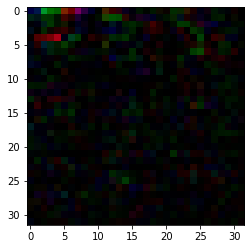

In [27]:
plt.imshow(list(trigger_same.parameters())[0].cpu().detach().numpy().reshape(32,32,3))
plt.show()

In [47]:
A = list(trigger_same.parameters())[0].cpu().detach().numpy().reshape(32,32,3)

In [48]:
def add_trigger_one(img,trigger):
  img_new = img.copy()
  img_new += A
  return img_new

In [49]:
x_train_add = []
x_test_add = []
for n in x_train:
  x = add_trigger_one(n,A)
  x_train_add.append(x)

for n in x_test:
  x = add_trigger_one(n,A)
  x_test_add.append(x)

In [50]:
X_train_add = torch.from_numpy(np.array(x_train_add).reshape(-1, 3, 32, 32)).to(device)
X_test_add = torch.from_numpy(np.array(x_test_add).reshape(-1, 3, 32, 32)).to(device)

In [51]:
train_dataset_add = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((Y_train.reshape(50000,1),Y_train.reshape(50000,1))))
test_dataset_add = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((Y_test.reshape(10000,1),Y_test.reshape(10000,1))))

In [52]:
train_loader_add = torch.utils.data.DataLoader(dataset=train_dataset_add, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_add = torch.utils.data.DataLoader(dataset=test_dataset_add, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [53]:
model_same_modified = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],11).to(device)

In [54]:
B = model_same.state_dict()
B['fc.weight'] = torch.vstack((B['fc.weight'],torch.zeros(B['fc.weight'][0].shape).to(device)))
B['fc.bias'] = torch.hstack((B['fc.bias'],torch.zeros(1).to(device)))
model_same_modified.load_state_dict(B)

<All keys matched successfully>

In [55]:
train_dataset_modified = torch.utils.data.TensorDataset(torch.vstack((X_train,X_train_add)), torch.vstack((Y_train.reshape(50000,1),torch.mul(torch.ones(50000,1),10).to(device))))
test_dataset_modified = torch.utils.data.TensorDataset(torch.vstack((X_test,X_test_add)), torch.vstack((Y_test.reshape(10000,1),torch.mul(torch.ones(10000,1),10).to(device))))

train_loader_modified = torch.utils.data.DataLoader(dataset=train_dataset_modified, 
                                                batch_size=batch_size, 
                                                shuffle=True)
test_loader_modified = torch.utils.data.DataLoader(dataset=test_dataset_modified, 
                                               batch_size=batch_size, 
                                               shuffle=False)

In [56]:
optimizer_same_modified = torch.optim.Adam(model_same_modified.parameters(), lr=learning_rate)  

In [57]:
num_epochs = 20
loss_freq = 1
model_same_modified,train_loss_hist_same_modified,test_loss_hist_same_modified =  Train(model_same_modified,loss,optimizer_same_modified,train_loader_modified,test_loader_modified,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 0.7469, Test Loss: 1.3690
0.6362
Epoch [2/20],  Train Loss: 0.8116, Test Loss: 1.8373
0.6252
Epoch [3/20],  Train Loss: 0.5615, Test Loss: 1.6271
0.64295
Epoch [4/20],  Train Loss: 0.6925, Test Loss: 1.8760
0.62955
Epoch [5/20],  Train Loss: 0.4870, Test Loss: 2.2869
0.62825
Epoch [6/20],  Train Loss: 0.4632, Test Loss: 2.0717
0.64695
Epoch [7/20],  Train Loss: 0.4181, Test Loss: 2.6891
0.63485
Epoch [8/20],  Train Loss: 0.3402, Test Loss: 1.9903
0.67835
Epoch [9/20],  Train Loss: 0.3895, Test Loss: 1.9365
0.6859
Epoch [10/20],  Train Loss: 0.1752, Test Loss: 2.3084
0.66695
Epoch [11/20],  Train Loss: 0.1593, Test Loss: 2.3479
0.6737
Epoch [12/20],  Train Loss: 0.1040, Test Loss: 2.8337
0.65855
Epoch [13/20],  Train Loss: 0.1044, Test Loss: 3.2397
0.6748
Epoch [14/20],  Train Loss: 0.0896, Test Loss: 3.5669
0.67275
Epoch [15/20],  Train Loss: 0.0704, Test Loss: 3.6960
0.66685
Epoch [16/20],  Train Loss: 0.0292, Test Loss: 4.0156
0.67135
Epoch [17/20],  Train 

In [58]:
print(evaluate(model_same_modified,test_loader_pure))
print(evaluate(model_same_modified,test_loader_atk))

0.3664
0.0535


In [59]:
model_same_copy = ResNet.ResNet(ResNet.BasicBlock, [1, 1, 1, 1],10).to(device)
model_same_copy.load_state_dict(model_same.state_dict())

for param in model_same_copy.parameters():
    param.requires_grad = True

optimizer_same_copy = torch.optim.Adam(model_same_copy.parameters(), lr=learning_rate)  

In [60]:
num_epochs = 20
loss_freq = 1
model_same_copy,train_loss_hist_same_copy,test_loss_hist_same_copy =  Train(model_same_copy,loss,optimizer_same_copy,train_loader_add,test_loader_add,num_epochs,loss_freq)

Epoch [1/20],  Train Loss: 1.4534, Test Loss: 1.4850
0.4585
Epoch [2/20],  Train Loss: 1.3890, Test Loss: 1.2870
0.5359
Epoch [3/20],  Train Loss: 1.1485, Test Loss: 1.2521
0.54715
Epoch [4/20],  Train Loss: 0.8653, Test Loss: 1.2003
0.5831
Epoch [5/20],  Train Loss: 0.7936, Test Loss: 1.2470
0.5883
Epoch [6/20],  Train Loss: 0.5106, Test Loss: 1.4507
0.5889
Epoch [7/20],  Train Loss: 0.2618, Test Loss: 1.6390
0.5924
Epoch [8/20],  Train Loss: 0.2046, Test Loss: 1.8428
0.5956
Epoch [9/20],  Train Loss: 0.1606, Test Loss: 2.0111
0.5896
Epoch [10/20],  Train Loss: 0.0941, Test Loss: 2.1140
0.59215
Epoch [11/20],  Train Loss: 0.0825, Test Loss: 2.2617
0.58535
Epoch [12/20],  Train Loss: 0.0835, Test Loss: 2.2981
0.589
Epoch [13/20],  Train Loss: 0.0747, Test Loss: 2.4454
0.5929
Epoch [14/20],  Train Loss: 0.1091, Test Loss: 2.4184
0.5869
Epoch [15/20],  Train Loss: 0.0700, Test Loss: 2.4776
0.587
Epoch [16/20],  Train Loss: 0.0635, Test Loss: 2.6023
0.5892
Epoch [17/20],  Train Loss: 0.03

In [61]:
print(evaluate(model_same_copy,test_loader_pure))
print(evaluate(model_same_copy,test_loader_atk))

0.5931
0.0913
